In [ ]:
# default_exp display


In [ ]:
# hide
from fastcore.all import *

# Displaying objects in notebooks

This module provides support for displaying objects, such as instance of GTSAM classes.


## Showing graphs

For showing graphs, Graphviz and its python wrapper need to be installed. I did that with `conda install python-graphviz` which also installs graphviz, but these are installed by default on Google's colabs.


In [ ]:
# export
import gtsam
import graphviz
from gtbook.discrete import Variables
from gtbook.dbn import dbn_writer


Some GTSAM objects have a `dot` method, but notebooks cannot render this. We use a trick, by the following small class, inherting from `graphviz.Source` :


In [ ]:
# export
class show(graphviz.Source):
    """ Display an object with a dot method as a graph."""

    def __init__(self, obj, *args, **kwargs):
        """Construct from object with 'dot' method."""
        # This small class takes an object, calls its dot function, and uses the
        # resulting string to initialize a graphviz.Source instance. This in turn
        # has a _repr_mimebundle_ method, which then renders it in the notebook.
        if args and isinstance(args[0], Variables):
            assert len(args) == 1, "Variables must be only positional argument."
            keyFormatter = args[0].keyFormatter()
            # Special treatment of DBN positions
            engine = "dot"
            writer = dbn_writer(obj, **kwargs)
            if writer is not None:
                engine = "neato"
                kwargs["writer"] = writer
            super().__init__(obj.dot(keyFormatter, **kwargs), engine=engine)
        else:
            super().__init__(obj.dot(*args, **kwargs))


In [ ]:
from gtsam import DiscreteBayesNet

Asia = (0, 2)
Smoking = (1, 2)
Tuberculosis = (2, 2)
LungCancer = (3, 2)
Either = (4, 2)

bayesNet = DiscreteBayesNet()
bayesNet.add(Asia, "99/1")
bayesNet.add(Smoking, "50/50")
bayesNet.add(Tuberculosis, [Asia], "99/1 95/5")
bayesNet.add(LungCancer, [Smoking], "99/1 90/10")
bayesNet.add(Either, [Tuberculosis, LungCancer], "F T T T")


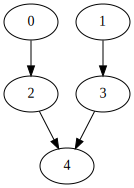

In [ ]:
show(bayesNet)


We can, however, create our own formatter in python, and pass it as an optional argument:


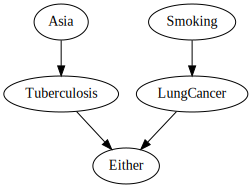

In [ ]:
domain = ["Asia", "Smoking", "Tuberculosis", "LungCancer", "Either"]
def keyFormatter(key): return domain[key]


show(bayesNet, keyFormatter)


It also works for factor graphs, as illustrated below:


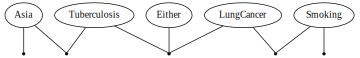

In [ ]:
# convert bayesNet to a factor graph and render:
from gtsam import DiscreteFactorGraph
fg = DiscreteFactorGraph(bayesNet)
show(fg, keyFormatter)


Factor graph graphviz rendering can be customized even more, through a DotWriter object. For example, the following displays the "primamry constraint graph":


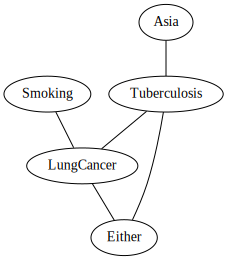

In [ ]:
from gtsam import DotWriter
writer = DotWriter(figureWidthInches=5, figureHeightInches=5,
                   plotFactorPoints=False, binaryEdges=False)
show(fg, keyFormatter, writer)


Individual factors can also be shown, althoug arrows are not labeled (yet):


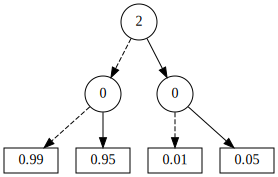

In [ ]:
show(fg.at(2))


## Markdown

Markdown can be rendered natively, like so:


In [ ]:
bayesNet


DiscreteBayesNet
 
size: 5
factor 0:  P( 0 ):
 Choice(0) 
 0 Leaf 0.99
 1 Leaf 0.01

factor 1:  P( 1 ):
 Leaf  0.5

factor 2:  P( 2 | 0 ):
 Choice(2) 
 0 Choice(0) 
 0 0 Leaf 0.99
 0 1 Leaf 0.95
 1 Choice(0) 
 1 0 Leaf 0.01
 1 1 Leaf 0.05

factor 3:  P( 3 | 1 ):
 Choice(3) 
 0 Choice(1) 
 0 0 Leaf 0.99
 0 1 Leaf  0.9
 1 Choice(1) 
 1 0 Leaf 0.01
 1 1 Leaf  0.1

factor 4:  P( 4 | 2 3 ):
 Choice(4) 
 0 Choice(3) 
 0 0 Choice(2) 
 0 0 0 Leaf    1
 0 0 1 Leaf    0
 0 1 Leaf    0
 1 Choice(3) 
 1 0 Choice(2) 
 1 0 0 Leaf    0
 1 0 1 Leaf    1
 1 1 Leaf    1

However, to provide optional arguments, we have to resort to a similar trick:


In [ ]:
# export
class pretty:
    """Render an object as html with optional arguments."""

    def __init__(self, obj, *args):
        if args and isinstance(args[0], Variables):
            assert len(args) == 1, "Variables must be only argument."
            variables = args[0]
            if isinstance(obj, gtsam.DiscreteValues):
                self._md = variables.values_html(obj)
            else:
                self._md = obj._repr_html_(
                    variables.keyFormatter(), variables.names())
        else:
            if isinstance(obj, gtsam.DiscreteValues):
                self._md = f"{obj}"
            else:
                self._md = obj._repr_html_(*args)

    def _repr_html_(self):
        return self._md


In [ ]:
pretty(bayesNet, keyFormatter)


Factor graphs work as well:


In [ ]:
graph = DiscreteFactorGraph()
graph.add([Asia, Smoking], "4 1 10 4")
pretty(graph, keyFormatter)


Asia,Smoking,value
0,0,4
0,1,1
1,0,10
1,1,4


And Bayes trees:


In [ ]:
fg = DiscreteFactorGraph(bayesNet)
bt = fg.eliminateMultifrontal()
pretty(bt, keyFormatter)


And with a different (worse) ordering:


In [ ]:
ordering = gtsam.Ordering()
ordering.push_back(Either[0])
ordering.push_back(LungCancer[0])
ordering.push_back(Tuberculosis[0])
ordering.push_back(Smoking[0])
ordering.push_back(Asia[0])
bt2 = fg.eliminateMultifrontal(ordering)
pretty(bt2, keyFormatter)


Tuberculosis,Smoking,Asia,value
0,0,0,0.49005
0,0,1,0.00475
0,1,0,0.49005
0,1,1,0.00475
1,0,0,0.00495
1,0,1,0.00025
1,1,0,0.00495
1,1,1,0.00025
Smoking,Tuberculosis,0,1
0,0,0.99,0.01


## Domains


We also provide support for the `Variables` data structure:


In [ ]:
variables = Variables()
T = variables.discrete("Tuberculosis", ["-", "+"])
L = variables.discrete("LungCancer", ["No", "Yes"])
C = variables.discrete("Either", ["Nope", "One or both"])

fragment = DiscreteBayesNet()
fragment.add(T, "99/1")
fragment.add(L, "50/50")
fragment.add(C, [T, L],  "F T T T")


In [ ]:
pretty(fragment, variables)


In [ ]:
assignment = variables.assignment({C: "Nope"})
assert pretty(assignment)._repr_html_() == 'DiscreteValues{2: 0}'
pretty(assignment, variables)


Variable,value
Either,Nope


And of course, showing a graph as well:


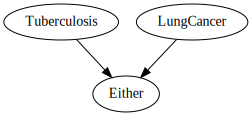

In [ ]:
show(fragment, variables)

## Formatting HMMS

HMMs, and in general dynamic Bayes nets, should really be shown left to right. We create a writer with appropriate `variablePositions` is the object given to `show` is a Bayes net with X/A/Z variables:

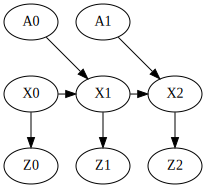

In [ ]:
A = variables.discrete_series('A', range(2), ["U", "D"])
X = variables.discrete_series('X', range(3), ["room1", "room2"])
Z = variables.discrete_series('Z', range(3), ["light", "dark"])
hmm = DiscreteBayesNet()
hmm.add(X[0], "99/1")
for k in range(2):
    hmm.add(A[k], [],  "3/4")
    hmm.add(X[k+1], [X[k], A[k]],  "1/2 3/4 1/2 3/4")
for k in range(3):
    hmm.add(Z[k], [X[k]],  "1/2 3/4")
show(hmm, variables)

# Art

We also provide some facilities for displaying some random art:


In [ ]:
# export
from IPython.display import HTML
import random

ROBOTS = ["Robot%20menagerie", "Trash%20sorting%20robot%20with%20gripper", "iRobot%20vacuuming%20robot", "Warehouse%20robots",
          "Two-wheeled%20Toy%20Robot", "Autonomous%20Vehicle%20with%20LIDAR%20and%20cameras", "Autonomous%20camera%20drone"]


def randomImages(ch: int, sec: int, style: str, nrImages: int, maxIndex: int = 8):
    """Create an HTML element with some random images.

    Args:
        ch (int): chapter number (base 1)
        sec (int): section number
        style (str): "cubist" | "steampunk" | "expressive"
        nrImages (int): number of images
        maxIndex (int, optional): Indexes to sample from. Defaults to 8.

    Returns:
        HTML: div with nrImages
    """
    perc = round(100/nrImages)
    robot = ROBOTS[ch-1]

    def image_tag(index):
        url = f"https://github.com/gtbook/robotics/blob/main/Art/{style}/S{ch}{sec}-{robot}-{index:02d}.jpg?raw=1"
        return f"<img src='{url}' style='height:256 width:{perc}%'/>"
    indices = random.sample(range(maxIndex), nrImages)
    return HTML(f"""
        <div align='center'>
        {" ".join([image_tag(index) for index in indices])}
        </div>
        """)


In [ ]:
from IPython.display import display
for ch in range(1, 8):
    print(ROBOTS[ch-1])
    display(randomImages(ch, 3, "steampunk", 1))


Robot%20menagerie


Trash%20sorting%20robot%20with%20gripper


iRobot%20vacuuming%20robot


Warehouse%20robots


Two-wheeled%20Toy%20Robot


Autonomous%20Vehicle%20with%20LIDAR%20and%20cameras


Autonomous%20camera%20drone
